# Performance of a logistic regression model on RNA-Seq data for genes with shared pathways vs non-shared pathways

### Mira Welner May 2024

The PIRM algorithm uses relational biomarkers to classify biological samples as case or control. However, it does not take into consideration the biological processes that the two genes which correspond to the two sets of biomarkers are involved in. If PIRM is using the counts of two genes as biomarkers, it looks only at the counts of the two genes; it does not take into account what functions those genes actually perform. It would be interesting to know if the pairs of genes that PIRM is identifying have anything in common, or perform tasks similar to ones that might be expected for genes involved in preeclampsia.

One metric that can be used to determine if two genes have anything in common is shared pathways. If a gene plays a role in a biological process, it is said to be on that process's pathway. If two genes are on the same pathway, then they are both components of a specific biological task and are related in that sense. 

Many genes have been identified by previous publications (such as Quake) as being related to preeclampsia. 128 of these genes were collected from multiple papers, and the PathwayCommons API was used to determine whether those genes shared pathways. RNA-Seq counts were loaded for these genes, and two logistic regression models were trained: one model used the RNA-Seq counts for N genes all on the same pathway, and the other had the counts for N genes which had no pathways in common. For various different N values, these two models were compared. It was found that for lower N values, genes on different pathways performed better while for higher N values, genes on the same pathways did better.

## 1) Gene Selection

The first step was to identify several papers in the literature which identify genes which are likely to be related to preeclamptia. I identified 15 papers including the Quake paper. They are as follows:

* [Global gene expression analysis of cell-free RNA in amniotic fluid from women destined to develop preeclampsia](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6370049/) (Jung)
* [Inflammation in Preeclampsia: Genetic Biomarkers, Mechanisms, and Therapeutic Strategies](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9307876/) (Wang)
* [Evaluation of Current and New Biomarkers in Severe Preeclampsia: A Microarray Approach Reveals the VSIG4 Gene as a Potential Blood Biomarker](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3859491/) (Textoris)
* [Cost and resource implications with serum angiogenic factor estimation in the triage of preeclampsia](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3744598/) (Schnettler)
* [Gene-Centric Analysis of Preeclampsia Identifies Maternal Association at PLEKHG1](https://www.ahajournals.org/doi/10.1161/HYPERTENSIONAHA.117.10688) (Gray)
* [The H19 Gene Imprinting in Normal Pregnancy and Pre-eclampsia](https://www.sciencedirect.com/science/article/abs/pii/S0143400409000782?via%3Dihub) (Yu)
* [Susceptibility to pre-eclampsia is associated with multiple genetic polymorphisms in maternal biotransformation enzymes](https://pubmed.ncbi.nlm.nih.gov/17167268/) (Zusterzeel)
* [Candidate-Gene Association Study of Mothers with Pre-Eclampsia, and Their Infants, Analyzing 775 SNPs in 190 Genes](https://karger.com/hhe/article-abstract/63/1/1/160855/Candidate-Gene-Association-Study-of-Mothers-with?redirectedFrom=fulltext) (Goddard)
* [Bioinformatics methods in biomarkers of preeclampsia and associated potential drug applications](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-022-08937-3) (Peng)
* [Maternal whole blood mRNA signatures identify women at risk of early preeclampsia: a longitudinal study](https://pubmed.ncbi.nlm.nih.gov/31900005/) (Tarca)
* [Identification of potential early biomarkers of preeclampsia](https://www.sciencedirect.com/science/article/abs/pii/S0143400417312043) (Timofeeva)
* [The Differential Expression of ERAP1/ERAP2 and Immune Cell Activation in Pre-eclampsia](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7076169/) (Seamon)
* [Gene expression profiling of pre-eclamptic placentae by RNA sequencing](https://www.nature.com/articles/srep14107) (Kaartokallio)
* [The genetics of pre-eclampsia and other hypertensive disorders of pregnancy](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3145161/) (Williams)
* [Early prediction of preeclampsia in pregnancy with cell-free RNA](https://pubmed.ncbi.nlm.nih.gov/35140405/) (Moufarrej) <-- the Quake paper

While I believe that these 15 papers provide a good sample of the existing literature, it might be worth it for somebody who is more familiar with the biological literature to take a look.

These 15 papers yielded the following 128 genes:

In [1]:
import pandas as pd
pe_gene_data = pd.read_csv('gene_data/genes.csv')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pe_gene_data)

          name              code         Paper
0        RPS29  ENSG00000213741           Jung
1       EEF1A1   ENSG00000156508          Jung
2         IGF2  ENSG00000167244           Jung
3          UBC   ENSG00000150991          Jung
4          FAU  ENSG00000149806           Jung
5          FTL   ENSG00000087086          Jung
6       TMSB10   ENSG00000034510          Jung
7        ARNT2  ENSG00000172379           Jung
8     HIST1H4A   ENSG00000278637          Jung
9       ZNF346   ENSG00000113761          Jung
10       OPRK1  ENSG00000082556           Wang
11        BTG2   ENSG00000159388          Wang
12        TPBG   ENSG00000146242          Wang
13       INHBA   ENSG00000122641          Wang
14       RPL17   ENSG00000265681      Textoris
15       RPL23   ENSG00000125691      Textoris
16       RPL26   ENSG00000161970      Textoris
17       RPL27   ENSG00000131469      Textoris
18       RPL31  ENSG00000071082       Textoris
19       RPL34   ENSG00000109475      Textoris
20       SNRP

In this dataframe,  The `code` column represents the Ensembl ID of the gene. The Ensembl database contains information about many different genes and the corresponding Ensembl ID codes are useful for two reasons:

1) Our RNA-Seq counts, which I will talk about later, are labled with Ensembl IDs. So in order to load the counts for the genes we need the Ensembl codes

2) They are often more specific than the common gene names. For example, in the Quake paper Extended Data Table 4, it lists the common name `Y_RNA` twice, as it corresponds to two different Ensembl codes. Similarly, in the Zusterzeel paper, the gene EPHX is mentioned. However in the Ensembl datatabase it is more specific and contains seperate data for EPHX1, EPHX2, and EPHX3.

The `name` column in the dataframe represents the commonly used name of the gene. It is worth noting that sometimes a gene has multiple names. For example the Schnettler paper refered to the gene `sFlt1` which represents "plasma soluble fms-like tyrosine kinase-1". However sFlt1 could not be found in the Ensembl database! The Ensembl database did contain Flt1 (FMS-like tyrosine kinase 1), and FLT1 (fms related receptor tyrosine kinase 1). I checked in with DP who informed me that they are orthologues, so I went with FLT1 which is the human version rather than the mouse, and the Schnettler paper used humans rather than mice. There are a few such similar situations where the proper Ensembl code is tricky to find. 

Some of the genes in this list are duplicates, because they were mentioned twice in different papers.  For example, the LEP gene was mentioned in both the Kaartokallio paper and the Peng paper so there are two entries for LEP. I included two entries for LEP, one corresponding to each paper, because in general it is relevant that the genes are mentioned in two different papers. However it isn't relevant for this particular notebook, so when the names and ensembl codes of the genes are loaded, duplicates are removed

In [2]:
genes = list(set(pe_gene_data['code']))
len(genes)

121

6 duplicates are removed leaving us with 121 genes

## 2) Processing Counts Data

PIRM is a very generalizable algorithm that can predict outcomes for samples given many different types of biomarkers. One such biomarker is RNA-Seq counts. RNA-Seq is a transcriptome analysis method. Rather than analyzing the genome, which would indicate what genes could potentially be expressed, it analyzes the transcriptome to find out what genes are actually being expressed in the sample. When RNA-Seq is run on a biological sample, it returns data regarding the <b>number of reads for a given gene in the RNA of a biological sample</b>. So for example, if a sample `Sample A` has RNA-Seq run on it, and the sequencing method detects RNA fragments or 'reads' that align with `Gene B` 30 times, then `Sample A` will have a count of 30 for Gene B.

We have 37 samples which have had RNA-Seq run on them. As an example, lets look at the sample `PL1013`. It is a control sample meaning that it represents an individual who did not have preeclampsia. In our sample `PL1013`, the gene `ENSG00000000419` is found 35 times in the RNA. So, for `PL1013`, the RNA count for `ENSG00000000419` is 35. 

Here is our RNA-Seq data

In [3]:
unprocessed_counts = pd.read_csv('gene_data/pe-rna-counts.csv', index_col=0)
unprocessed_counts

,PL1013,PL1015,PL1023,PL1043,PL1159,PL1182,PL1226,PL1362,PL1365,PL1383,...,PL2353,PL2360,PL2406,PL475,PL519,PL629,PL687,PL808,PL810,PL893
ENSG00000000419,35.000,200.000,1181.000,414.000,0.0,1039.000,89.000,851.0,0.0,389.000,...,1211.001,997.000,1210.000,253.000,0.0,368.0,619.000,1023.000,453.000,0.000
ENSG00000000457,403.000,0.000,50.000,564.000,304.0,321.000,585.000,466.0,0.0,119.000,...,549.000,1495.999,2717.001,612.000,520.0,9.0,518.000,666.000,201.000,365.000
ENSG00000000460,284.000,0.000,377.000,0.000,120.0,0.000,153.000,0.0,0.0,0.000,...,1209.000,668.000,0.000,120.000,0.0,242.0,556.000,405.000,65.000,0.000
ENSG00000000938,2863.000,1670.000,6676.001,4711.001,3291.0,2213.000,3877.000,3773.0,4064.0,6874.001,...,9406.000,27263.000,7853.000,2273.000,3769.0,1846.0,3838.999,11801.000,4797.000,4973.000
ENSG00000000971,0.000,20.000,666.000,83.289,0.0,0.000,0.000,197.0,0.0,963.000,...,0.000,348.000,197.000,38.000,0.0,54.0,0.000,204.815,0.000,61.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000293497,0.000,19.000,701.001,87.000,0.0,0.000,40.000,0.0,0.0,96.000,...,13.000,421.651,0.000,34.000,385.0,0.0,305.000,605.999,127.000,0.000
ENSG00000293508,0.000,1.000,172.000,273.000,0.0,0.000,173.000,0.0,0.0,305.000,...,4.000,0.000,7.000,0.000,82.0,349.0,333.000,166.000,0.000,8.000
ENSG00000293510,200.000,252.000,0.000,121.000,716.0,0.000,546.000,10.0,0.0,97.000,...,0.000,616.218,352.705,0.000,82.0,55.0,1282.000,1253.569,365.000,60.000
ENSG00000293514,202.000,196.000,407.000,190.000,0.0,0.000,950.000,288.0,0.0,0.000,...,0.000,683.000,325.000,246.000,0.0,140.0,0.000,201.000,716.000,1075.000


Now one problem with the above data is that it is highly skewed. So we run `np.log1p` which adds 1 to every value and then takes the log of every value. The reason that 1 is added to the data before the log is taken is so it doesn't break for counts of 0

In [4]:
import numpy as np
rng = np.random.default_rng(seed=5952) 
unfiltered_counts = np.log1p(unprocessed_counts)
unfiltered_counts

,PL1013,PL1015,PL1023,PL1043,PL1159,PL1182,PL1226,PL1362,PL1365,PL1383,...,PL2353,PL2360,PL2406,PL475,PL519,PL629,PL687,PL808,PL810,PL893
ENSG00000000419,3.583519,5.303305,7.074963,6.028279,0.000000,6.946976,4.499810,6.747587,0.000000,5.966147,...,7.100028,6.905753,7.099202,5.537334,0.000000,5.910797,6.429719,6.931472,6.118097,0.000000
ENSG00000000457,6.001415,0.000000,3.931826,6.336826,5.720312,5.774552,6.373320,6.146329,0.000000,4.787492,...,6.309918,7.311218,7.907652,6.418365,6.255750,2.302585,6.251904,6.502790,5.308268,5.902633
ENSG00000000460,5.652489,0.000000,5.934894,0.000000,4.795791,0.000000,5.036953,0.000000,0.000000,0.000000,...,7.098376,6.505784,0.000000,4.795791,0.000000,5.493061,6.322565,6.006353,4.189655,0.000000
ENSG00000000938,7.959975,7.421178,8.806424,8.457868,8.099251,7.702556,8.263075,8.235891,8.310169,8.835647,...,9.149209,10.213322,8.968778,7.729296,8.234830,7.521318,8.253227,9.376024,8.475954,8.511980
ENSG00000000971,0.000000,3.044522,6.502790,4.434251,0.000000,0.000000,0.000000,5.288267,0.000000,6.871091,...,0.000000,5.855072,5.288267,3.663562,0.000000,4.007333,0.000000,5.326978,0.000000,4.127134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000293497,0.000000,2.995732,6.553935,4.477337,0.000000,0.000000,3.713572,0.000000,0.000000,4.574711,...,2.639057,6.046547,0.000000,3.555348,5.955837,0.000000,5.723585,6.408527,4.852030,0.000000
ENSG00000293508,0.000000,0.693147,5.153292,5.613128,0.000000,0.000000,5.159055,0.000000,0.000000,5.723585,...,1.609438,0.000000,2.079442,0.000000,4.418841,5.857933,5.811141,5.117994,0.000000,2.197225
ENSG00000293510,5.303305,5.533389,0.000000,4.804021,6.575076,0.000000,6.304449,2.397895,0.000000,4.584967,...,0.000000,6.425222,5.868463,0.000000,4.418841,4.025352,7.156956,7.134547,5.902633,4.110874
ENSG00000293514,5.313206,5.283204,6.011267,5.252273,0.000000,0.000000,6.857514,5.666427,0.000000,0.000000,...,0.000000,6.527958,5.786897,5.509388,0.000000,4.948760,0.000000,5.308268,6.575076,6.981006


As you can see in the below histogram, these log counts are reasonably symmetrical, although there are a lot of counts of zero.

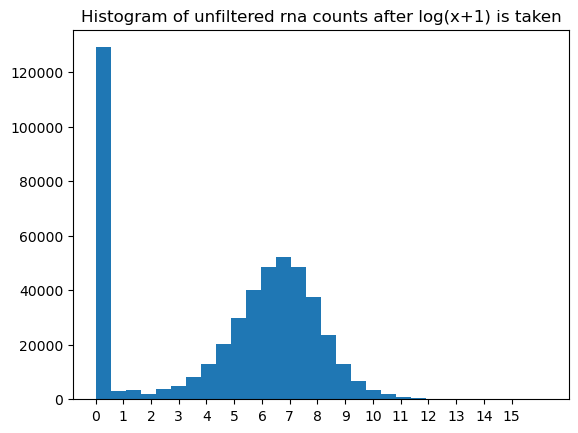

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(unfiltered_counts.stack(), bins=30)
plt.xticks(list(range(16)))
plt.title("Histogram of unfiltered rna counts after log(x+1) is taken")
plt.show()

Now we need to filter the counts so that they only contain the 120 genes that were identified in the literature. However there is a problem - of the 120 genes, not all of them are found in our RNA-Seq database. 

In [6]:
len([code for code in genes if code in unfiltered_counts.index])

79

It would appear that only 79 are in our counts database. So we filter out the counts to only contain those 79 genes

In [7]:
counts = unfiltered_counts.loc[[g for g in genes if g in unfiltered_counts.index]]
counts

,PL1013,PL1015,PL1023,PL1043,PL1159,PL1182,PL1226,PL1362,PL1365,PL1383,...,PL2353,PL2360,PL2406,PL475,PL519,PL629,PL687,PL808,PL810,PL893
ENSG00000115414,4.934474,6.113682,6.298949,5.351858,4.234107,7.581210,6.708084,6.541030,7.587817,7.433667,...,6.946013,0.000000,8.542666,5.662960,6.716594,4.875197,3.806662,6.974479,7.055313,7.057898
ENSG00000077238,7.548556,6.049733,7.043160,6.859613,7.536897,0.000000,7.525101,7.230563,0.000000,6.940222,...,8.173576,8.264878,7.884577,6.423247,5.099866,6.340361,7.905810,7.956827,7.429521,6.755769
ENSG00000232810,5.416100,4.644391,4.532599,6.480045,0.000000,6.871091,4.948760,5.318120,0.000000,4.276666,...,6.701960,5.583496,6.109248,3.663562,1.098612,0.000000,0.000000,5.564520,2.708050,4.691348
ENSG00000131469,9.662944,9.103089,10.850366,10.864312,9.455558,8.664578,10.885959,10.035130,8.878358,10.234660,...,10.908741,11.117628,11.036775,10.671858,9.703450,9.446203,10.752013,11.110027,10.342839,10.319959
ENSG00000187474,0.000000,4.584967,6.054439,0.000000,6.511745,0.000000,0.000000,3.555348,0.000000,0.000000,...,4.624973,0.000000,5.117994,0.000000,0.000000,0.000000,3.555348,4.234107,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000154429,4.897840,5.823046,7.157735,6.100319,0.693147,0.000000,7.050989,0.000000,3.891820,4.962845,...,7.480992,6.768493,7.091742,5.758902,5.934894,5.036953,6.194405,6.539586,5.872118,6.196444
ENSG00000173511,7.381502,6.632002,7.677864,7.649216,6.317165,6.870053,7.633370,7.052721,6.739337,6.740519,...,7.930206,7.288244,7.198184,7.363914,3.637586,6.590301,7.608871,7.956477,7.701200,5.872118
ENSG00000112715,0.000000,6.257668,0.000000,5.192957,5.993961,0.000000,0.000000,5.802118,0.000000,6.276643,...,6.352629,7.633854,0.000000,5.347108,4.709530,6.272877,5.723585,5.652489,4.744932,5.402677
ENSG00000163428,4.330733,5.877736,7.454720,6.587550,7.715124,6.429719,6.948897,5.736572,6.748760,6.551080,...,7.188413,6.175867,7.643483,6.516193,6.350886,5.986452,4.890349,7.728856,6.834109,5.472271


Lets reset the `genes` variable to the 79 genes that are both in the literature and in our counts table

In [8]:
genes = counts.index

## 3) Create a ground truth for the samples

The above counts table contains 37 samples and 79 genes. We are trying to create a predictive model for these 37 samples that takes their counts as input and gives their class as output. In this case, their class is either `case` or `ctrl`. `case` means they had preeclamsia and `ctrl` means they did not. To do this, we need a 'ground truth' variable to map each of the 37 samples to their class.

We have a file, called `pe-rna-metadata.csv`, which we will use to create this ground truth

In [9]:
raw_meta = pd.read_csv('gene_data/pe-rna-metadata.csv',header=None, names=["sample", "classification"]).T
raw_meta

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
sample,PL1013,PL1015,PL1023,PL1043,PL1159,PL1182,PL1226,PL1362,PL1365,PL1383,...,PL2353,PL2360,PL2406,PL475,PL519,PL629,PL687,PL808,PL810,PL893
classification,Control,Mild,Mild,Mild,Control,Control,Severe,Mild,Control,Severe,...,Mild,Severe,Severe,Severe,Severe,Severe,Mild,Mild,Mild,Severe


The `sample` row lists the sample IDs, and the `classification` lists the class. However you will notice that the class is not `case` or `ctrl`, it is `Control`, `Mild`, or `Severe`. It seperates whether the individual had severe or mild preeclampsia. While this is an important distinction, for now we are going to ignore it. So we change the classes to `ctrl` and `case`

First though we turn the `sample` row into the dataframe's column names so the dataframe is easier to work with

In [10]:
catagorical_ground_truth = pd.DataFrame(raw_meta.values[1:], columns=raw_meta.iloc[0])
catagorical_ground_truth.columns.name = None
catagorical_ground_truth

,PL1013,PL1015,PL1023,PL1043,PL1159,PL1182,PL1226,PL1362,PL1365,PL1383,...,PL2353,PL2360,PL2406,PL475,PL519,PL629,PL687,PL808,PL810,PL893
0,Control,Mild,Mild,Mild,Control,Control,Severe,Mild,Control,Severe,...,Mild,Severe,Severe,Severe,Severe,Severe,Mild,Mild,Mild,Severe


Now the column names are the ID and the row `0` is the class. Given this, we can use a dictionary to translate it into the `case` and `ctrl` classes

In [11]:
ground_truth = [{"Control": "ctrl", "Severe": "case", "Mild": "case"}.get(item, item) for item in list(catagorical_ground_truth.loc[0])]
print(ground_truth)

['ctrl', 'case', 'case', 'case', 'ctrl', 'ctrl', 'case', 'case', 'ctrl', 'case', 'case', 'ctrl', 'ctrl', 'ctrl', 'case', 'ctrl', 'case', 'ctrl', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case', 'case']


And the above list is the ground truth values that we will be using for the samples when putting them in the logistic regression model

## 4) Create the Pathway Dictionaries

Now it is time to begin querying PathwayCommons. PathwayCommons has an api which, given a particular gene, will return the pathways it is associated. For example with the gene ENSG00000174697 (LEP):

In [12]:
import requests
r = requests.get("https://www.pathwaycommons.org/pc2/top_pathways?q=ENSG00000174697").text
print(r)

{"numHits":10,"maxHitsPerPage":10,"searchHit":[{"uri":"http://pathwaycommons.org/pc12/Pathway_01bff9503a224b616e5fe2c149f272e0","biopaxClass":"Pathway","name":"Signaling events mediated by PTP1B","dataSource":["http://pathwaycommons.org/pc12/Provenance_16dc1eb6f42ce7a52939ce2863d7741f"],"organism":["http://identifiers.org/taxonomy/9606"],"pathway":[],"excerpt":null,"numParticipants":129,"numProcesses":105},{"uri":"http://pathwaycommons.org/pc12/Pathway_5217fa2506fc68746a24f8dec7533594","biopaxClass":"Pathway","name":"Heterotrimeric GPCR signaling pathway (through G alpha i and pertussis toxin) ( GPCR signaling (pertussis toxin) )","dataSource":["http://pathwaycommons.org/pc12/Provenance_08d11acf3d81d0dc782c73f449d45c81"],"organism":["http://pathwaycommons.org/pc12/BioSource_ac5528a8a6fea5e83d93cac4c3d5112e"],"pathway":[],"excerpt":null,"numParticipants":34,"numProcesses":8},{"uri":"http://pathwaycommons.org/pc12/Pathway_3d5d6ea7c8106bb64171839b91cee036","biopaxClass":"Pathway","name":"

The above JSON string contains data regarding each pathway. The name of the pathway comes after the string "name" and before the string "datasource". Thus, in order to get every pathway name out of the datastring we can use the following regular expression

In [13]:
import re
re.findall(r'"Pathway","name":"(.*?)","dataSource":', requests.get("https://www.pathwaycommons.org/pc2/top_pathways?q=ENSG00000174697").text)

['Signaling events mediated by PTP1B',
 'Heterotrimeric GPCR signaling pathway (through G alpha i and pertussis toxin) ( GPCR signaling (pertussis toxin) )',
 'Heterotrimeric GPCR signaling pathway (through_G alpha s_ACs_PKA_BRaf_and_ERKcascade)(canonical) ( GPCR signaling (G alpha s, PKA and ERK) )',
 'Leptin',
 'Heterotrimeric GTP-binding protein coupled receptor signaling pathway (through G alpha i, adenylate cyclase and cAMP) ( GPCR signaling (G alpha i) )',
 'Heterotrimeric GPCR signaling pathway (through G alpha s ACs Epac BRaf and ERKcascade) ( GPCR signaling (G alpha s, Epac and ERK) )',
 'HIF-1-alpha transcription factor network',
 'Heterotrimeric GPCR signaling pathway (through G alpha q, PLC beta and ERK cascade) ( GPCR signaling (G alpha q) )',
 'Heterotrimeric GTP-binding protein coupled receptor signaling pathway (through_G_alpha_s,_cholera_toxin,_adenylate_cyclase_and_cAMP) ( GPCR signaling (cholera toxin) )',
 'TSH']

Using this, we can create the `gene_to_pathway` dictionary. This dictionary maps the genes (which are the keys) to a list of pathways corresponding to that gene

In [14]:
from tqdm import tqdm
gene_to_pathway = {}
for g in tqdm(genes):
    gene_to_pathway[g] = re.findall(
        r'"Pathway","name":"(.*?)","dataSource":',
        requests.get(
            "https://www.pathwaycommons.org/pc2/top_pathways?q=" + g
        ).text,
    )
gene_to_pathway

100%|██████████| 79/79 [00:28<00:00,  2.73it/s]


{'ENSG00000115414': ['Beta3 integrin cell surface interactions',
  'Angiopoietin receptor Tie2-mediated signaling',
  'Extracellular matrix organization',
  'Alpha4 beta1 integrin signaling events',
  'Syndecan-4-mediated signaling events',
  'Integrin signaling pathway ( Integrin signaling pathway )',
  'VEGFR3 signaling in lymphatic endothelium',
  'Integrins in angiogenesis',
  'Beta5 beta6 beta7 and beta8 integrin cell surface interactions',
  'Integrin signalling pathway',
  'Beta1 integrin cell surface interactions',
  'Urokinase-type plasminogen activator (uPA) and uPAR-mediated signaling',
  'Syndecan-2-mediated signaling events',
  'Alpha9 beta1 integrin signaling events'],
 'ENSG00000077238': ['IL-13 signaling pathway(JAK1 TYK2 STAT6) ( IL-13 signaling(JAK1 TYK2 STAT6) )',
  'IL-4 signaling pathway(JAK1 JAK3 STAT6) ( IL-4 signaling(JAK1 JAK3 STAT6) )',
  'IL4',
  'Interleukin signaling pathway',
  'IL4-mediated signaling events',
  'p73 transcription factor network',
  'JAK-S

For the genes in our dataset, how many pathways do they typically have?

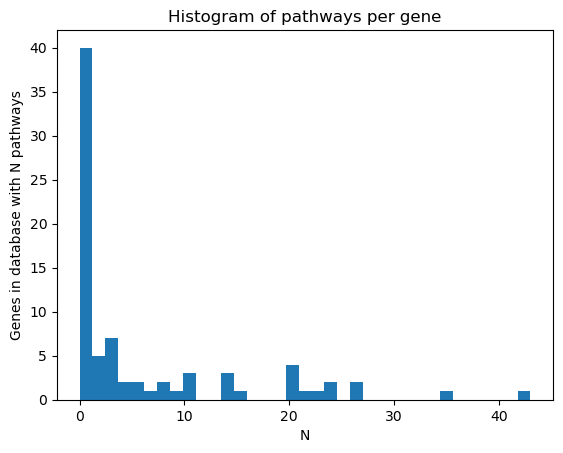

In [15]:
lengths = [len(g_list) for g_list in gene_to_pathway.values()]
fig = plt.figure()
plt.hist(lengths, bins=35)
plt.ylabel("Genes in database with N pathways")
plt.xlabel("N")
plt.title("Histogram of pathways per gene")
plt.show()

So we have a pretty wide distribution, with a high peak at 0. This begs the question, why are there so many genes with no pathways? This kind of looks like an error. The below list are all the genes with zero pathways

In [16]:
for gene, pathways in gene_to_pathway.items():
    if len(pathways) == 0:
        print(gene)

ENSG00000164308
ENSG00000164307
ENSG00000120278
ENSG00000115956
ENSG00000106733
ENSG00000132109
ENSG00000138688
ENSG00000163348
ENSG00000111961
ENSG00000160194
ENSG00000099256
ENSG00000100109
ENSG00000112773
ENSG00000130203
ENSG00000137496
ENSG00000007944
ENSG00000114942
ENSG00000034510
ENSG00000163162
ENSG00000105497
ENSG00000165810
ENSG00000211448
ENSG00000187605
ENSG00000125691
ENSG00000070404
ENSG00000113761
ENSG00000170542
ENSG00000155659
ENSG00000113296
ENSG00000105492
ENSG00000241973
ENSG00000130600
ENSG00000087086
ENSG00000103005
ENSG00000154429
ENSG00000163428


It looks like there are 61 genes that have no pathways. Lets look at a few of their API responses!

In [17]:
requests.get("https://www.pathwaycommons.org/pc2/top_pathways?q=ENSG00000207992").text

'{"numHits":0,"maxHitsPerPage":0,"searchHit":[],"pageNo":0,"comment":"Top Pathways (technically, each has empty index field \'pathway\'; that also means, they are neither components of other pathways nor controlled of any process)","version":"12","providers":[],"empty":true}'

In [18]:
requests.get("https://www.pathwaycommons.org/pc2/top_pathways?q=ENSG00000254636").text

'{"numHits":0,"maxHitsPerPage":0,"searchHit":[],"pageNo":0,"comment":"Top Pathways (technically, each has empty index field \'pathway\'; that also means, they are neither components of other pathways nor controlled of any process)","version":"12","providers":[],"empty":true}'

So as you can see, this did not get an error response, these genes are all genes that are found within PathwayCommons, but they just don't have pathways associated with them (according to PathwayCommons). So it doesn't seem like the zero pathway results were an error

Another dictionary that could be helpful is a 'flipped' version of the above dictionary, which maps pathways to lists of corresponding genes

In [19]:
from collections import defaultdict
pathways_to_genes = defaultdict(list)
for gene, pathways in gene_to_pathway.items():
    for pathway in pathways:
        pathways_to_genes[pathway].append(gene)
pathways_to_genes = dict(pathways_to_genes)
pathways_to_genes

{'Beta3 integrin cell surface interactions': ['ENSG00000115414',
  'ENSG00000259207',
  'ENSG00000112715'],
 'Angiopoietin receptor Tie2-mediated signaling': ['ENSG00000115414',
  'ENSG00000232810',
  'ENSG00000164867'],
 'Extracellular matrix organization': ['ENSG00000115414'],
 'Alpha4 beta1 integrin signaling events': ['ENSG00000115414'],
 'Syndecan-4-mediated signaling events': ['ENSG00000115414'],
 'Integrin signaling pathway ( Integrin signaling pathway )': ['ENSG00000115414',
  'ENSG00000259207'],
 'VEGFR3 signaling in lymphatic endothelium': ['ENSG00000115414',
  'ENSG00000150630'],
 'Integrins in angiogenesis': ['ENSG00000115414',
  'ENSG00000259207',
  'ENSG00000184371',
  'ENSG00000017427',
  'ENSG00000112715'],
 'Beta5 beta6 beta7 and beta8 integrin cell surface interactions': ['ENSG00000115414'],
 'Integrin signalling pathway': ['ENSG00000115414'],
 'Beta1 integrin cell surface interactions': ['ENSG00000115414',
  'ENSG00000112715'],
 'Urokinase-type plasminogen activator 

Lets look at the distributions of the genes per pathway!

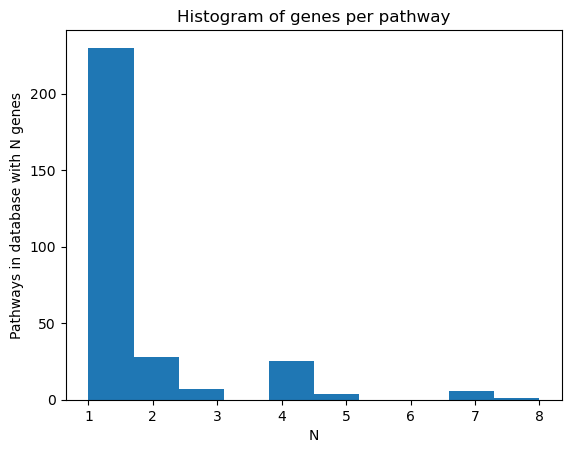

In [20]:
lengths = [len(p_list) for p_list in pathways_to_genes.values()]
fig = plt.figure()
plt.hist(lengths, bins=10)
plt.ylabel("Pathways in database with N genes")
plt.xlabel("N")
plt.title("Histogram of genes per pathway")
plt.show()

So it looks like no pathway has more than 8 genes. One thing that I am curious about is, for the pathways with more than 6 genes, are they the same genes in all the pathways?

In [21]:
for gene_list in [gene_list for gene_list in pathways_to_genes.values() if len(gene_list) > 6]:
    print(gene_list)

['ENSG00000232810', 'ENSG00000017427', 'ENSG00000122641', 'ENSG00000150630', 'ENSG00000173511', 'ENSG00000112715', 'ENSG00000174697']
['ENSG00000232810', 'ENSG00000017427', 'ENSG00000122641', 'ENSG00000150630', 'ENSG00000173511', 'ENSG00000112715', 'ENSG00000174697']
['ENSG00000232810', 'ENSG00000017427', 'ENSG00000122641', 'ENSG00000150630', 'ENSG00000173511', 'ENSG00000112715', 'ENSG00000174697']
['ENSG00000232810', 'ENSG00000017427', 'ENSG00000122641', 'ENSG00000150630', 'ENSG00000173511', 'ENSG00000112715', 'ENSG00000174697']
['ENSG00000232810', 'ENSG00000017427', 'ENSG00000122641', 'ENSG00000150630', 'ENSG00000173511', 'ENSG00000112715', 'ENSG00000174697']
['ENSG00000232810', 'ENSG00000017427', 'ENSG00000122641', 'ENSG00000150630', 'ENSG00000173511', 'ENSG00000112715', 'ENSG00000174697']
['ENSG00000159399', 'ENSG00000134107', 'ENSG00000147872', 'ENSG00000106366', 'ENSG00000104419', 'ENSG00000181163', 'ENSG00000112715', 'ENSG00000174697']


It looks like all the pathways with 7 genes have the same genes, and then there is one pathway with 8 genes.

What are the pathways with 7 genes?

In [22]:
for p in [p for p, gene_list in pathways_to_genes.items() if len(gene_list) == 7]:
    print(p)

Heterotrimeric GPCR signaling pathway (through G alpha i and pertussis toxin) ( GPCR signaling (pertussis toxin) )
Heterotrimeric GPCR signaling pathway (through_G alpha s_ACs_PKA_BRaf_and_ERKcascade)(canonical) ( GPCR signaling (G alpha s, PKA and ERK) )
Heterotrimeric GTP-binding protein coupled receptor signaling pathway (through G alpha i, adenylate cyclase and cAMP) ( GPCR signaling (G alpha i) )
Heterotrimeric GPCR signaling pathway (through G alpha s ACs Epac BRaf and ERKcascade) ( GPCR signaling (G alpha s, Epac and ERK) )
Heterotrimeric GPCR signaling pathway (through G alpha q, PLC beta and ERK cascade) ( GPCR signaling (G alpha q) )
Heterotrimeric GTP-binding protein coupled receptor signaling pathway (through_G_alpha_s,_cholera_toxin,_adenylate_cyclase_and_cAMP) ( GPCR signaling (cholera toxin) )


## 5) Get N genes on the same pathway

Our goal is to see whether N genes on the same pathway, or N genes all on different pathways, yeild better results. So now it is time to get sets of genes to start training our regression model. First, we will create a function to get a set of N genes, all of which share a pathway. However in order to avoid overfitting, it gets two different pathways and then takes N genes from the test pathway and N from the train pathway, and thus creates a set of test and train genes.

One limitation of this function is that if there is any overlap between the test and the train set, it just samples the data to get another test set, until there is no overlap between the genes in the test and train set. While this works, and runs nearly instantly, it's not the most satisfying way to get two non-overlapping sets. But I'm keeping it for now because it's fast and works.

Note that we cannot use the standard scikit learn test/train split builtin method. This is because in order to do that we would have to have a set of data which is then randomly split. In order to do this we would have to get a set of 2N genes on one pathway and split it into test and train sections, rather than getting two sets of N genes from two different pathways. This is an issue because then we would require a pathway with 2N genes for every N and there are not enough pathways with high numbers of genes. So this is a better method.

In [23]:
def get_pathway_genes(N):
    pathways_with_min_N_genes = list(set([pathway for pathway, genes in pathways_to_genes.items() if len(genes)>=N]))

    train_pathway_genes = np.random.choice(pathways_to_genes[np.random.choice(pathways_with_min_N_genes)], size=N, replace=False).tolist()
    while True:
        test_pathway_genes = np.random.choice(pathways_to_genes[np.random.choice(pathways_with_min_N_genes)], size=N, replace=False).tolist()
        if not set(train_pathway_genes).intersection(test_pathway_genes):
            break

    return train_pathway_genes, test_pathway_genes

In [24]:
get_pathway_genes(5)

(['ENSG00000173511',
  'ENSG00000112715',
  'ENSG00000150630',
  'ENSG00000017427',
  'ENSG00000232810'],
 ['ENSG00000120915',
  'ENSG00000173083',
  'ENSG00000159399',
  'ENSG00000177000',
  'ENSG00000164867'])

## 6) Get N genes all on different pathways
Now we need to get the groups of genes which are on different pathways. To get both a test and train set for this, 2N genes are sampled. Half are used for the training set and half for the testing set. Then it is ensured that the sets of pathways for each of those genes have no overlap, meaning they are not on the same pathways. If they do have overlap, they are resampled.

This is probably not the most mathmatically efficient way to do this but it runs fast given our sample size.

In [25]:
def interesetion(pathways):
    genes = [gene for sub_list in pathways for gene in sub_list]
    return len(genes) == len(set(genes))

def get_random_genes(N):
    while True:
        Nx2_genes = np.random.choice(genes, size=N*2, replace=False).tolist()
        test_genes = Nx2_genes[:N]
        train_genes = Nx2_genes[N:]
        test_pathways = [gene_to_pathway[g] for g in test_genes]
        train_pathways = [gene_to_pathway[g] for g in train_genes]
        intersect_test = interesetion(test_pathways)
        intersect_train = interesetion(train_pathways)
        if intersect_test and intersect_train:
            return test_genes, train_genes


In [26]:
get_random_genes(5)

(['ENSG00000150991',
  'ENSG00000254087',
  'ENSG00000104419',
  'ENSG00000164308',
  'ENSG00000007944'],
 ['ENSG00000138688',
  'ENSG00000173369',
  'ENSG00000164867',
  'ENSG00000278637',
  'ENSG00000163428'])

If this particular algorithm keeps being used for larger datasets, it will be worth revisiting ways to make it more efficient, but for now, I will leave it as is

## 7) Load the counts which correspond with the genes
Now that we have lists of genes, we need to load their RNA-Seq counts which is what will be used to train the logistic regression model. So the `get_random_genes` and `get_pathway_genes` rows are selected from the counts table, and then the index is dropped. The index is dropped or else the scikit-learn `LogisticRegression` will assume that these are feature labels and complain that the test and train feature labels are not the same

In [27]:
def train_test_counts(train_genes, test_genes):
    train_counts = counts.loc[train_genes, :]
    test_counts = counts.loc[test_genes, :]
    train_counts.reset_index(drop=True, inplace=True)
    test_counts.reset_index(drop=True, inplace=True)
    return train_counts, test_counts

In [28]:
train_pathway_counts, test_pathway_counts = train_test_counts(*get_pathway_genes(3))
train_random_counts, test_random_counts = train_test_counts(*get_random_genes(3))

Here is an example of what the counts dataframes look like:

In [29]:
train_pathway_counts

,PL1013,PL1015,PL1023,PL1043,PL1159,PL1182,PL1226,PL1362,PL1365,PL1383,...,PL2353,PL2360,PL2406,PL475,PL519,PL629,PL687,PL808,PL810,PL893
0,0.000000,6.056784,6.558198,5.697093,0.000000,6.120297,6.426488,6.396930,6.35437,5.575949,...,8.346405,8.584104,7.331715,6.023448,6.270988,5.880533,7.294377,6.580639,6.327937,5.075174
1,6.086775,6.040255,6.978214,6.003890,0.000000,0.000000,2.197225,6.150603,0.00000,0.000000,...,4.343805,6.242223,0.000000,4.477337,0.000000,3.526361,0.000000,6.450470,3.663562,0.000000
2,0.000000,1.098612,5.257495,5.961005,0.693147,7.470224,5.318120,4.867534,0.00000,0.000000,...,0.693147,6.356108,0.000000,6.846943,0.000000,4.204693,5.834811,6.541030,4.828314,0.000000


## 8) Why logistic regression?

PIRM has already been run on these RNA-seq samples. However this notebook does not run PIRM on our 37 RNA samples - it runs logistic regression. There are two main reasons why we are running logistic regression on these samples when we already have PIRM.

<b>Reason 1</b>: A good number of the existing studies regarding biomarkers indicating the presence or absence of preeclampsia use logistic regression. For example, the Quake paper uses logistic regression. It would therefore make sense for us to use logistic regression as some sort of 'benchmark' for PIRM. PIRM does not have to perform better than logistic regression in all cases but it is still valuble to know how it compares.

<b>Reason 2</b>: PIRM uses linear regression. When additional variables are added to linear regression, each additional variable yields diminishing returns. However logistic regression can run on any number of genes and adding more genes does not yield diminishing returns. This is useful because there are certain relationships such as covariate independence and covariate correlation which require three or more data points. Logistic regression allows us to use any number of samples, and the covariate independence and covariate correlation can be studied.

Therefore for this notebook, I will be running logistic regression on RNA-Seq data to determine how good of a model it is

Then we create a logistic regression model, fit it to the train counts and test it on the test counts. The accuracy is simply the number of correct predictions over predictions made

In [30]:
from sklearn.linear_model import LogisticRegression
def model_accuracy(train_counts, test_counts, random_state=None):
    clf = LogisticRegression(random_state=random_state).fit(train_counts.T, ground_truth)
    y_pred = clf.predict(test_counts.T)
    accuracy = y_pred==ground_truth
    return sum(accuracy)/len(accuracy)

## 9) Analyzing results

To determine whether shared pathways improve the results, we train and test 100 logistic regression models and plot the mean testing accuracy. For the below plot, the Y axis is the accuracy and the X axis the number of genes used to train the logistic regression model (N). N ranges from 2 to 5. 

It is notable that the standard deviation among the 100 runs is pretty high

In [31]:
def logistic_path_vs_nonpath(N, itt):
    different_pathway_accuracy = []
    same_pathway_accuracy = []

    for _ in range(itt):
        train_pathway_genes, test_pathway_genes = get_pathway_genes(N)
        train_random_genes, test_random_genes = get_random_genes(N)

        train_pathway_counts, test_pathway_counts = train_test_counts(train_pathway_genes, test_pathway_genes)
        train_random_counts, test_random_counts = train_test_counts(train_random_genes, test_random_genes)

        same_pathway_accuracy.append(model_accuracy(train_pathway_counts, test_pathway_counts))
        different_pathway_accuracy.append(model_accuracy(train_random_counts, test_random_counts))

    return same_pathway_accuracy, different_pathway_accuracy


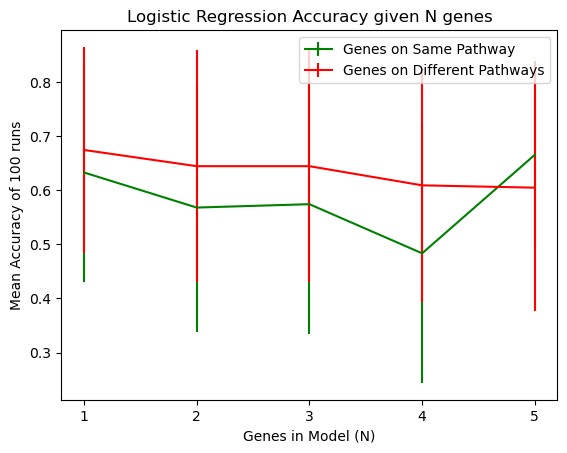

In [32]:
x = list(range(1,6))
s, s_err, d, d_err = [[] for _ in range(4)]
itt = 100
for n in x:
    same, diff = logistic_path_vs_nonpath(n, itt)
    s.append(np.mean(same))
    s_err.append(np.std(same))
    d.append(np.mean(diff))
    d_err.append(np.std(diff))
plt.errorbar(x, s, yerr=s_err, color='green', label='Genes on Same Pathway')
plt.errorbar(x, d, yerr=d_err, color='red', label="Genes on Different Pathways")
plt.xticks(x)
plt.ylabel(f"Mean Accuracy of {itt} runs")
plt.xlabel("Genes in Model (N)")
plt.title("Logistic Regression Accuracy given N genes")
plt.legend()
plt.show()

It would appear that when different pathways do better other than when N=5.

## 10) One important limitation in this model

As you can see in the below plot, as N gets larger there are fewer and fewer pathways that can be chosen that contain N genes. Now while it is entirely possible that the pathways which have lots of genes have the best genes for the preeclampsia model, it is also possible that they do not. Therefore as N gets larger, there is an unknown limitation entering the model. It might make the results better or it may make them worse, we do not know. However it is worth noting that as N grows, certian genes are being eliminated from the dataset of shared-pathway genes. Since the N genes which do not share a pathway can come from any group of pathways, but the N genes from the same pathway can only come from a pathway with at least N genes, this will affect our results.

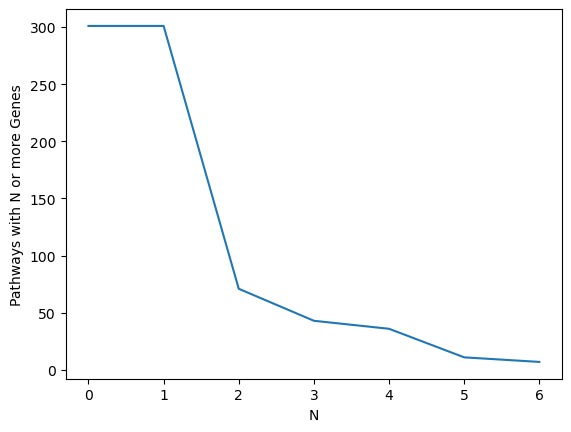

In [33]:
x = list(range(7))
plt.plot(x, [len([pathway for pathway, genes in pathways_to_genes.items() if len(genes)>=n]) for n in x] )
plt.ylabel("Pathways with N or more Genes")
plt.xlabel("N")
plt.show()